In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [34]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
import numpy as np
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import nltk

# Load data
dat = pd.read_csv('/content/drive/MyDrive/Neural Net and Deep Learning Files/IMDB Dataset.csv')

# Use 50000 samples
dat = dat.iloc[0:50000, ]

# Map sentiment labels to 1 (positive) and 0 (negative)
dat['sentiment'] = dat['sentiment'].map({"positive": 1, 'negative': 0})

# Split the data into train and test sets
train_df, test_df = train_test_split(dat, test_size=0.15, random_state=1)

# Load Word2Vec model
model_path = '/content/drive/MyDrive/Neural Net and Deep Learning Files/GoogleNews-vectors-negative300.bin.gz'
word2vec_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
embedding_matrix = torch.FloatTensor(word2vec_model.vectors)

# Define LSTM-based model
class LSTMSentimentAnalysis(nn.Module):
    def __init__(self, input_size, hidden_size, output_dim):
        super(LSTMSentimentAnalysis, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=0)
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out[:, -1, :]  # Take the last time step output
        output = self.fc(lstm_out)
        output = self.sigmoid(output)
        return output


# Download NLTK punkt package
nltk.download('punkt')

# Convert text to vector using your text_to_sequence function
def text_to_sequence(sentence, max_length):
    sentence = sentence.lower()
    tokens = word_tokenize(sentence)
    indices = [word2vec_model.key_to_index[word] for word in tokens if word in word2vec_model.key_to_index]
    # Pad or truncate the sequence to the specified max_length
    indices = indices[:max_length] + [0] * max(0, max_length - len(indices))
    return torch.tensor(indices, dtype=torch.long)


# Create a DataLoader for the training set
train_reviews = [text_to_sequence(sentence, max_length=100) for sentence in train_df['review']]
train_sentiments = train_df['sentiment'].tolist()

class IMDBDataset(Dataset):
    def __init__(self, reviews, sentiments):
        self.reviews = reviews
        self.sentiments = sentiments

    def __len__(self):
        return len(self.sentiments)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        sentiment = torch.tensor(self.sentiments[idx], dtype=torch.float32)
        return review, sentiment

def collate_batch(batch):
    # Separate the reviews and the sentiments
    reviews, sentiments = zip(*batch)

    # Filter out empty reviews
    non_empty_reviews = [review for review in reviews if review.size(0) > 0]

    if not non_empty_reviews:
        return torch.tensor([]), torch.tensor([])

    # Pad the sequences to have the same length
    # padding_value is typically the index of the padding token, often 0.
    reviews_padded = pad_sequence(non_empty_reviews, batch_first=True, padding_value=0)

    # Stack sentiments into a single tensor
    sentiments_stacked = torch.stack(sentiments)

    return reviews_padded, sentiments_stacked

train_dataset = IMDBDataset(train_reviews, train_sentiments)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_batch)

# Initialize the model, criterion, and optimizer
input_dim = 300  # Update with the correct input dimension
hidden_size = 50  # Adjust according to your needs
output_dim = 1
model = LSTMSentimentAnalysis(input_dim, hidden_size, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch 1/10, Loss: 0.6841, Accuracy: 0.5623
Epoch 2/10, Loss: 0.4691, Accuracy: 0.7718
Epoch 3/10, Loss: 0.3739, Accuracy: 0.8311
Epoch 4/10, Loss: 0.3469, Accuracy: 0.8424
Epoch 5/10, Loss: 0.3229, Accuracy: 0.8568
Epoch 6/10, Loss: 0.3020, Accuracy: 0.8677
Epoch 7/10, Loss: 0.2811, Accuracy: 0.8779
Epoch 8/10, Loss: 0.2581, Accuracy: 0.8888
Epoch 9/10, Loss: 0.2335, Accuracy: 0.9014
Epoch 10/10, Loss: 0.2088, Accuracy: 0.9148


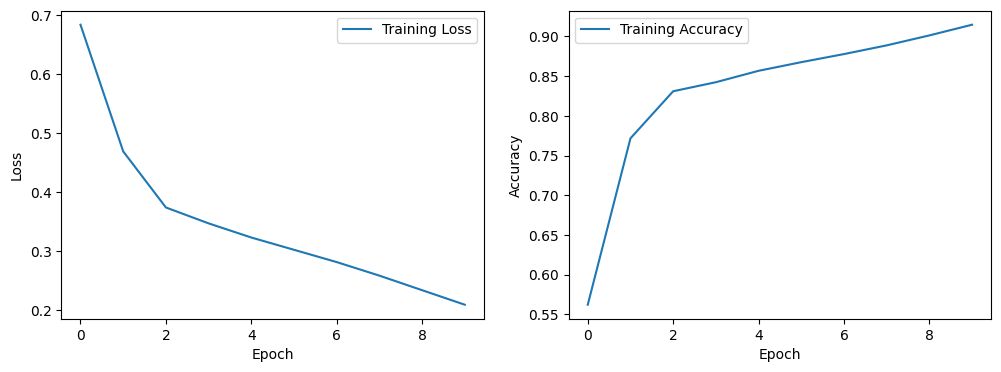

Testing Accuracy: 0.8517


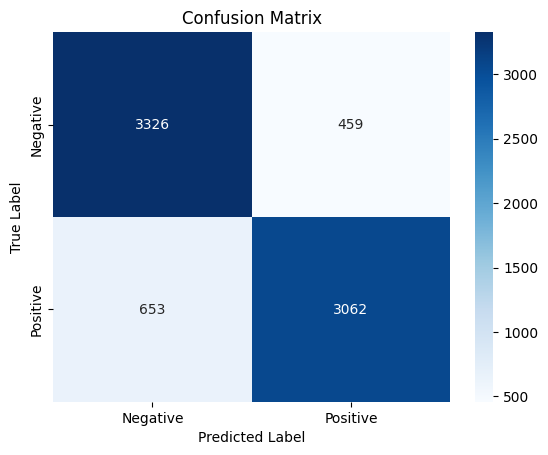

In [35]:
# Initialize lists to store training losses and accuracies
train_losses = []
train_accuracies = []

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for reviews, sentiments in train_loader:
        optimizer.zero_grad()
        outputs = model(reviews)
        loss = criterion(outputs.squeeze(), sentiments)
        loss.backward()
        optimizer.step()

        # Update counts for accuracy calculation
        predictions = (outputs >= 0.5).squeeze().long()
        correct_predictions += (predictions == sentiments.long()).sum().item()
        total_samples += sentiments.size(0)

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    train_accuracy = correct_predictions / total_samples

    # Store training loss and accuracy for plotting or analysis
    train_losses.append(average_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss:.4f}, Accuracy: {train_accuracy:.4f}")

# Plot training loss and accuracy over time
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluate on the testing set
model.eval()
test_reviews = [text_to_sequence(sentence, max_length=100) for sentence in test_df['review']]
test_sentiments = test_df['sentiment'].tolist()

test_dataset = IMDBDataset(test_reviews, test_sentiments)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_batch)

predictions = []
actuals = []

with torch.no_grad():
    for reviews, sentiments in test_loader:
        outputs = model(reviews)
        predictions.extend((outputs > 0.5).float().tolist())
        actuals.extend(sentiments.tolist())

# Calculate accuracy
accuracy = accuracy_score(actuals, predictions)
print(f'Testing Accuracy: {accuracy:.4f}')

# Create confusion matrix
conf_matrix = confusion_matrix(actuals, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


**Training loss and accuracy:**
*   The training loss consistently decreases over epochs, indicating effective learning.
*   Training accuracy steadily improves, reaching 91.48% by the 10th epoch.

**Model performance:**
*   The model demonstrates good performance with a testing accuracy of approximately 85.17%.

**Strengths**:
*   The model achieves a high number of True Positives and True Negatives, indicating effectiveness in classifying both positive and negative sentiments.

**Areas for Improvement:**
*   There is a notable number of False Negatives, suggesting that the model has difficulty identifying some positive sentiments.
*   Further hyperparameter tuning, experimenting with different architectures, or incorporating attention mechanisms may enhance performance.

**Training Duration:**
*   The model appears to converge well within the chosen 10 epochs.

**Recommendation:**
*   Consider experimenting with different embedding techniques or pre-trained models.
*   Fine-tune hyperparameters, especially those related to the LSTM layer and optimizer.
*   Investigate and address any potential class imbalance in the dataset.